### Import Library

In [1]:
# 이 중에서 안깔린 라이브러리가 있을 수 있음
import sys
import os
from typing import List, Dict, Tuple
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import QuantileTransformer


import seaborn as sns
import matplotlib.pyplot as plt
import pywt

sys.path.append(os.path.abspath('../'))  # 알아서 수정해 쓸 것
from func.utils import evaluate_model
import func.features as ft

from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

### Load Data

In [2]:
path = "../../../data/" # 본인 작업환경에 맞게 변경

train = pd.read_csv(path+"train.csv").assign(_type="train")
test = pd.read_csv(path+"test.csv").assign(_type="test")
submission = pd.read_csv(path+"test.csv")
df = pd.concat([train, test], axis=0)

# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:03<00:00, 31.34it/s]


In [3]:
df.isnull().sum().sort_values(ascending=False)

hourly_market-data_open-interest_gate_io_open_interest                11552
hourly_market-data_taker-buy-sell-stats_okex_taker_buy_volume         11552
hourly_market-data_open-interest_bitmex_open_interest                 11552
hourly_market-data_taker-buy-sell-stats_okex_taker_sell_volume        11552
hourly_market-data_taker-buy-sell-stats_okex_taker_buy_ratio          11552
                                                                      ...  
hourly_market-data_open-interest_htx_global_btc_usdt_open_interest        0
hourly_network-data_blockreward_blockreward_usd                           0
hourly_network-data_blockreward_blockreward                               0
_type                                                                     0
ID                                                                        0
Length: 255, dtype: int64

In [4]:
# 결측치 처리 - 칼럼 정리 

# 결측치 확인 및 처리를 위해 train, test로 분리 
train_df = df[df['_type'] == 'train']
test_df = df[df['_type'] == 'test']

# 결측치 많은 칼럼 확인
train_drop_cols = train_df.columns[train_df.isnull().sum() > 4000].tolist()
test_drop_cols = test_df.iloc[:, 2:].columns[test_df.iloc[:, 2:].isnull().sum() > 2000].tolist()
total_drop_cols = set(train_drop_cols).union(set(test_drop_cols))

# 결측치 많은 칼럼 제거 후 train, test 다시 병합
train_df = train_df.drop(total_drop_cols,axis=1)
test_df = test_df.drop(total_drop_cols,axis=1)


In [5]:
# 복사해서 보간 진행
tmp_train_df = train_df.drop(['ID', 'target', '_type'], axis=1).copy()
tmp_test_df = test_df.drop(['ID', 'target', '_type'], axis=1).copy()

# 결측치 처리 - 선형 보간법 (linear interpolation)
train_df_interpolated = tmp_train_df.interpolate(method='linear')
test_df_interpolated = tmp_test_df.interpolate(method='linear')

# 학습/테스트 데이터 부분 업데이트
train_df.update(train_df_interpolated)
test_df.update(test_df_interpolated)

# 결측치 처리 후 확인
print(train_df.isnull().sum())
print(test_df.isnull().sum())

# df로 다시 합치기
df= pd.concat([train_df, test_df], axis = 0)

ID                                                                           0
target                                                                       0
_type                                                                        0
hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume               0
hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume              0
                                                                            ..
hourly_market-data_open-interest_okx_all_symbol_open_interest                0
hourly_market-data_liquidations_gate_io_all_symbol_long_liquidations         0
hourly_market-data_liquidations_gate_io_all_symbol_short_liquidations        0
hourly_market-data_liquidations_gate_io_all_symbol_long_liquidations_usd     0
hourly_market-data_liquidations_gate_io_all_symbol_short_liquidations_usd    0
Length: 208, dtype: int64
ID                                                                              0
target                 

In [6]:
df= pd.concat([train_df, test_df], axis = 0)

In [7]:
def get_columns_with_many_zeros(df, threshold_ratio=0.5):
    """
    주어진 임계값 비율 이상의 0을 가진 열을 반환합니다.
    
    :param df: 데이터프레임
    :param threshold_ratio: 0의 비율 임계값 (기본값: 0.5, 즉 50%)
    :return: 임계값 이상의 0을 가진 열 이름 리스트
    """
    # 각 열에서 0의 개수를 계산
    zero_counts = (df == 0).sum()
    
    # 전체 행 수 대비 0의 비율 계산
    zero_ratios = zero_counts / len(df)
    
    # 임계값 이상의 0 비율을 가진 열 선택
    columns_with_many_zeros = zero_ratios[zero_ratios >= threshold_ratio].index.tolist()
    
    return columns_with_many_zeros

# 사용 예시
# df는 여러분의 데이터프레임입니다
columns_with_many_zeros = get_columns_with_many_zeros(df, threshold_ratio=0.5)
print("0이 많은 컬럼:", columns_with_many_zeros)

# 0이 많은 컬럼의 비율 출력
zero_ratios = (df == 0).sum() / len(df)
for col in columns_with_many_zeros:
    print(f"{col}: {zero_ratios[col]:.2%}")
print(len(columns_with_many_zeros))

0이 많은 컬럼: ['hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations', 'hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations', 'hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_usd', 'hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations_usd', 'hourly_market-data_liquidations_bybit_btc_usdt_long_liquidations', 'hourly_market-data_liquidations_bybit_btc_usdt_short_liquidations', 'hourly_market-data_liquidations_bybit_btc_usdt_long_liquidations_usd', 'hourly_market-data_liquidations_bybit_btc_usdt_short_liquidations_usd', 'hourly_market-data_liquidations_gate_io_btc_usd_long_liquidations', 'hourly_market-data_liquidations_gate_io_btc_usd_short_liquidations', 'hourly_market-data_liquidations_gate_io_btc_usd_long_liquidations_usd', 'hourly_market-data_liquidations_gate_io_btc_usd_short_liquidations_usd', 'hourly_market-data_liquidations_okx_btc_usd_long_liquidations', 'hourly_market-data_liquidations_okx_btc_usd_short_liquida

In [8]:
df.shape

(11552, 208)

In [9]:
# df = df.drop(columns_with_many_zeros, axis=1)

In [10]:
df.shape

(11552, 208)

### Quantile Transform 

In [11]:
# from sklearn.preprocessing import QuantileTransformer

# # 3번째 열부터 마지막 열까지 선택
# train_df_subset = df[df['_type'] == 'train'].iloc[:, 3:]
# test_df_subset = df[df['_type'] == 'test'].iloc[:, 3:]

# # 왜도 계산
# skewness = train_df_subset.skew()

# # 임계값 설정 (0.8 이상이면 right skewed, -0.3 이하면 left skewed로 구분)
# right_skewed = skewness[skewness > 0.8].index
# left_skewed = skewness[skewness < -0.3].index

# # Quantile Transform
# quantile_transformer_right = QuantileTransformer(output_distribution='normal', random_state=0)
# quantile_transformer_left = QuantileTransformer(output_distribution='normal', random_state=0)

# # train 데이터에 fit_transform 적용
# train_df_subset[right_skewed] = quantile_transformer_right.fit_transform(train_df_subset[right_skewed])
# train_df_subset[left_skewed] = quantile_transformer_left.fit_transform(train_df_subset[left_skewed])

# # test 데이터에 transform만 적용 (train에서 fit한 값을 기반으로 변환)
# test_df_subset[right_skewed] = quantile_transformer_right.transform(test_df_subset[right_skewed])
# test_df_subset[left_skewed] = quantile_transformer_left.transform(test_df_subset[left_skewed])

# df_subset = pd.concat([train_df_subset, test_df_subset], axis=0)
# df.iloc[:, 3:] = df_subset

### Feature engineering

#### Received Baseline

In [12]:
# 불필요한 접두사 제거 
df.columns = df.columns.str.replace('hourly_market-data_|hourly_network-data_', '', regex=True)
display(df.columns)

Index(['ID', 'target', '_type', 'taker-buy-sell-stats_bybit_taker_buy_volume',
       'taker-buy-sell-stats_bybit_taker_sell_volume',
       'taker-buy-sell-stats_bybit_taker_buy_ratio',
       'taker-buy-sell-stats_bybit_taker_sell_ratio',
       'taker-buy-sell-stats_bybit_taker_buy_sell_ratio',
       'liquidations_htx_global_btc_usd_long_liquidations',
       'liquidations_htx_global_btc_usd_short_liquidations',
       ...
       'blockreward_blockreward', 'blockreward_blockreward_usd',
       'difficulty_difficulty', 'utxo-count_utxo_count',
       'open-interest_binance_btc_usd_open_interest',
       'open-interest_okx_all_symbol_open_interest',
       'liquidations_gate_io_all_symbol_long_liquidations',
       'liquidations_gate_io_all_symbol_short_liquidations',
       'liquidations_gate_io_all_symbol_long_liquidations_usd',
       'liquidations_gate_io_all_symbol_short_liquidations_usd'],
      dtype='object', length=208)

In [13]:
# 제공된 피처 엔지니어링 적용
df = ft.make_baseline_extra(df)
df['liquidation_diff'] # 확인

0        0.012000
1       -0.712000
2        0.000000
3        0.593000
4        0.361000
           ...   
11547    0.466500
11548    6.431208
11549   -3.419327
11550   -0.853000
11551   -1.569674
Name: liquidation_diff, Length: 11552, dtype: float64

In [14]:
# 1. 날짜 피처 생성
df = ft.make_date(df, 'ID') 

# 2. Open Interest 관련 변동성, 차분 피처 생성
imp_open_interest_columns = [
    'open-interest_all_exchange_all_symbol_open_interest',
    'open-interest_binance_btc_usd_open_interest',
    'open-interest_okx_btc_usdt_open_interest',
    'open-interest_deribit_btc_usd_open_interest',
    'open-interest_deribit_all_symbol_open_interest',
    'open-interest_bybit_btc_usdt_open_interest',
    'open-interest_bitfinex_btc_usdt_open_interest',
    'open-interest_bybit_all_symbol_open_interest'
] 
df = ft.make_diff_change(df, imp_open_interest_columns) # 변동성, 차분 피처 

# 3. 롱/숏 비율
df = ft.make_liquidation_to_volume_ratio(df, 'liquidations_deribit_all_symbol_long_liquidations', 'liquidations_deribit_all_symbol_short_liquidations',
    'taker-buy-sell-stats_binance_taker_buy_volume', 'taker-buy-sell-stats_binance_taker_sell_volume') # 롱/숏 비율

# 4. 청산/거래량 비율
df = ft.make_liquidation_to_volume_ratio(df,'liquidations_deribit_all_symbol_long_liquidations', 'liquidations_deribit_all_symbol_short_liquidations',
    'taker-buy-sell-stats_binance_taker_buy_volume','taker-buy-sell-stats_binance_taker_sell_volume')

# 5. # 청산된 USD 롱/숏 비율
df = ft.make_liquidation_usd_ratio(df,'liquidations_deribit_all_symbol_long_liquidations_usd','liquidations_deribit_all_symbol_short_liquidations_usd')

# 6. 펀딩 비율과 롱/숏 포지션 차이 곱
df = ft.make_funding_rate_position_change(df, 'funding-rates_okx_funding_rates', 'liquidations_deribit_all_symbol_long_liquidations', 
    'liquidations_deribit_all_symbol_short_liquidations')

# 7. 프리미엄 갭과 프리미엄 인덱스의 차이
df = ft.make_premium_diff(df, 'coinbase-premium-index_coinbase_premium_gap', 'coinbase-premium-index_coinbase_premium_index')

# 8. 해시레이트와 난이도 간의 비율
df = ft.make_hashrate_to_difficulty(df, 'hashrate_hashrate', 'difficulty_difficulty')

# 9. 공급 변화율
df = ft.make_supply_change_rate(df, 'supply_supply_new', 'supply_supply_total')

# 10. Rolling(이동평균) 피처
df = ft.make_multiple_rolling(df, ['ID', 'target', '_type'] + ['year', 'month', 'week', 'day_of_week', 'hour'])

In [15]:
# 카테고리, 날짜, 롤링, 수치형 피처 분류
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
date_columns = ['ID', 'year', 'month', 'week', 'day_of_week', 'hour']
rolling_columns = [col for col in df.columns if 'rolling' in col]  # 'rolling'이 포함된 피처
conti_cols: List[str] = [col for col in df.columns if col not in category_cols + date_columns + rolling_columns + ['target', '_type']]

# 모든 수치형 컬럼에 대한 지수이동평균 계산
ema_dfs = []
for c in conti_cols:
    ema_df = ft.make_EMA(df, [c], 7)
    ema_df.columns = [f"{c}_moving_avg_7"]
    ema_dfs.append(ema_df)

# 원본 데이터프레임과 새로 계산된 EMA 데이터프레임들을 병합
df = pd.concat([df] + ema_dfs, axis=1)
    

# 모든 수치형 컬럼에 대한 Wavelet transform을 계산
wt_dfs = []
for c in conti_cols:
    wt_series = pd.Series(ft.make_WT(df, c), name=f"{c}_WT", index=df.index)
    wt_dfs.append(wt_series)

# 원본 데이터프레임과 새로 계산된 WT 시리즈들을 병합
df = pd.concat([df] + wt_dfs, axis=1)

# 최대 24시간의 shift 피쳐를 계산
shift_list = ft.make_shift(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in [1, 2, 5, 23, 47]]
)

In [16]:
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)
# df = df.loc[:, ~df.columns.duplicated()]
# df = df.drop(columns=new_features)

train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

### Model Training

In [17]:
# 칼럼 그룹 정리  (추후 실험에서 특정 피처들 포함/미포함을 쉽게 관리하기 위함. 교집합 없음)

# 기존 칼럼
addresses_columns = [col for col in df.columns if 'addresses' in col] # addresses(주소) 관련 피처. 변수명에 'addresses'포함
block_columns = [col for col in df.columns if 'block-' in col] # block(블록) 관련 피처. 변수명에 'block-' 포함 
blockreward_columns = [col for col in df.columns if 'blockreward' in col] # blockreward 관련 피처
difficulty_columns = [col for col in df.columns if 'difficulty' in col] # difficulty 관련 피처
fees_columns = [col for col in df.columns if 'fees' in col] # fees 관련 피처
hashrate_columns = [col for col in df.columns if 'hashrate' in col] # hashrate 관련 피처
supply_columns = [col for col in df.columns if 'supply_supply' in col] # supply 관련 피처
tokens_columns = [col for col in df.columns if 'tokens' in col] # tokens 관련 피처
transactions_columns = [col for col in df.columns if 'transactions' in col] # transactions 관련 피처
utxo_columns = [col for col in df.columns if 'utxo' in col] # utxo 관련 피처
velocity_columns = [col for col in df.columns if 'velocity' in col] # velocity 관련 피처
premium_columns = [col for col in df.columns if 'premium' in col] # premium 관련 피처
funding_rates_columns = [col for col in df.columns if 'funding_rates' in col] # funding rates 관련 피처
long_liquidation_columns = [col for col in df.columns if 'long_liquidation' in col] # 롱 청산 관련 피처
short_liquidation_columns = [col for col in df.columns if 'short_liquidation' in col] # 숏 청산 관련 피처
open_interest_columns = [col for col in df.columns if 'open_interest' in col] # open-interest 관련 피처
taker_columns = [col for col in df.columns if 'taker' in col] # taker 관련 피처

# 피처 엔지니어링
baseline_extra_columns = ['liquidation_diff', 'liquidation_usd_diff', 'volume_diff', 'liquidation_diffg', 'liquidation_usd_diffg', 'volume_diffg', 'buy_sell_volume_ratio'] # 게시글에 있는 베이스라인 코드의 피처
date_columns = ['ID', 'year', 'month', 'week', 'day_of_week', 'hour']
open_interest_diff_columns = [col for col in df.columns if '_diff' in col]
open_interest_pct_columns =[col for col in df.columns if '_pct_change' in col]
domain_related_columns = ['long_short_ratio', 'liquidation_to_volume_ratio', 'liquidation_usd_ratio', 'funding_rate_position_change', 'premium_diff', 'hashrate_to_difficulty', 'supply_change_rate']
rolling_columns = [col for col in df.columns if 'rolling' in col] # rolling 관련 피처
wt_columns = [col for col in df.columns if 'WT' in col] # WT 관련 피처
ema_columns = [col for col in df.columns if col.endswith('_moving_avg_7')] # WT 관련 피처
shift_7_columns = [series.name for series in shift_list] # shift list 피처 

# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [col for col in df.columns if col not in category_cols + date_columns + rolling_columns + ['target','_type']] # category_cols, date_columns, rolling_columns 에 있는 것들을 제외

#### lightGBM 학습

In [18]:
train_df.shape

(8760, 2794)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


acc: 0.4280821917808219, auroc: 0.6503833395946351

lgb_model 모델 평가

분류 보고서:
              precision    recall  f1-score   support

     Class 0       0.05      0.01      0.01       149
     Class 1       0.42      0.52      0.46       678
     Class 2       0.45      0.52      0.48       745
     Class 3       0.41      0.04      0.07       180

    accuracy                           0.43      1752
   macro avg       0.33      0.27      0.26      1752
weighted avg       0.40      0.43      0.39      1752

혼동 행렬:


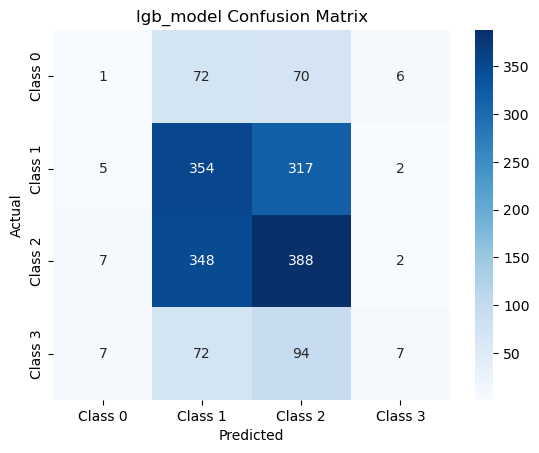

In [19]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42,
)

# lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params (베이스라인 코드의 기본 파라미터임)
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 0,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

# 추가된 confusion matrix 구현 부분
evaluate_model(y_valid, y_valid_pred_class, "lgb_model")

# Feature importance 부분

                                   feature   importance
170         liquidation_to_volume_ratio_WT  4716.924587
8                         taker_buy_volume  2745.855271
71          taker_sell_volume_moving_avg_7  1801.983486
9                        taker_sell_volume  1377.306896
110  open_interest_pct_change_moving_avg_7   757.149017
..                                     ...          ...
412                buy_sell_volume_ratio_2     0.000000
411                buy_sell_volume_ratio_1     0.000000
410                        volume_diffg_47     0.000000
109     buy_sell_volume_ratio_moving_avg_7     0.000000
101                utxo_count_moving_avg_7     0.000000

[461 rows x 2 columns]


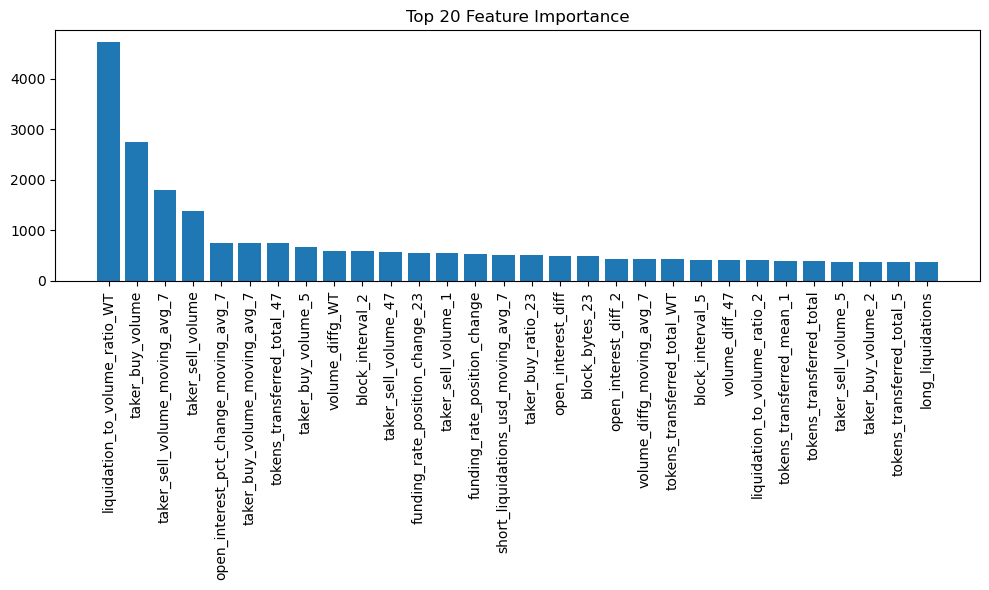

In [ ]:
# 모델 학습 후 특성 중요도 확인
feature_importance = lgb_model.feature_importance(importance_type='gain')
feature_names = lgb_model.feature_name()

# 특성 중요도를 데이터프레임으로 변환하고 정렬
import pandas as pd
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(feature_importance_df)

# 상위 30개 특성의 중요도를 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['feature'][:30], feature_importance_df['importance'][:30])
plt.xticks(rotation=90)
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()


In [ ]:
# importance 기준으로 오름차순 정렬
feature_importance_df_sorted = feature_importance_df.sort_values('importance', ascending=True)

# 하위 n개 선택
n = 500
bottom = feature_importance_df_sorted.head(n)

# 결과 출력 (모든 행 표시)
print(f"하위 {n}개 특성:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(bottom)

하위 500개 특성:
                                       feature   importance
338                             supply_total_5     0.000000
30                         fees_reward_percent     0.000000
32                                supply_total     0.000000
451                   hashrate_to_difficulty_1     0.000000
452                   hashrate_to_difficulty_2     0.000000
454                  hashrate_to_difficulty_23     0.000000
448                             premium_diff_5     0.000000
373                               utxo_count_5     0.000000
375                              utxo_count_47     0.000000
329                     fees_reward_percent_23     0.000000
330                     fees_reward_percent_47     0.000000
49                                       month     0.000000
337                             supply_total_2     0.000000
236                     taker_buy_sell_ratio_1     0.000000
339                            supply_total_23     0.000000
265                         

In [ ]:
# importance 기준으로 오름차순 정렬
feature_importance_df_sorted = feature_importance_df.sort_values('importance', ascending=False)

# 하위 n개 선택
n = 500
bottom = feature_importance_df_sorted.head(n)

# 결과 출력 (모든 행 표시)
print(f"하위 {n}개 특성:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(bottom)

하위 500개 특성:
                                       feature   importance
170             liquidation_to_volume_ratio_WT  4716.924587
8                             taker_buy_volume  2745.855271
71              taker_sell_volume_moving_avg_7  1801.983486
9                            taker_sell_volume  1377.306896
110      open_interest_pct_change_moving_avg_7   757.149017
70               taker_buy_volume_moving_avg_7   750.534741
350                tokens_transferred_total_47   745.529080
218                         taker_buy_volume_5   663.473098
165                            volume_diffg_WT   588.817249
267                           block_interval_2   586.090068
225                       taker_sell_volume_47   567.025554
444            funding_rate_position_change_23   557.906455
221                        taker_sell_volume_1   554.547550
58                funding_rate_position_change   524.495716
68         short_liquidations_usd_moving_avg_7   517.415298
229                         

                                   feature  importance
170         liquidation_to_volume_ratio_WT         127
8                         taker_buy_volume          95
165                        volume_diffg_WT          60
110  open_interest_pct_change_moving_avg_7          56
9                        taker_sell_volume          55
..                                     ...         ...
283                           difficulty_5           0
282                           difficulty_2           0
281                           difficulty_1           0
265                         block_count_47           0
94               supply_total_moving_avg_7           0

[461 rows x 2 columns]


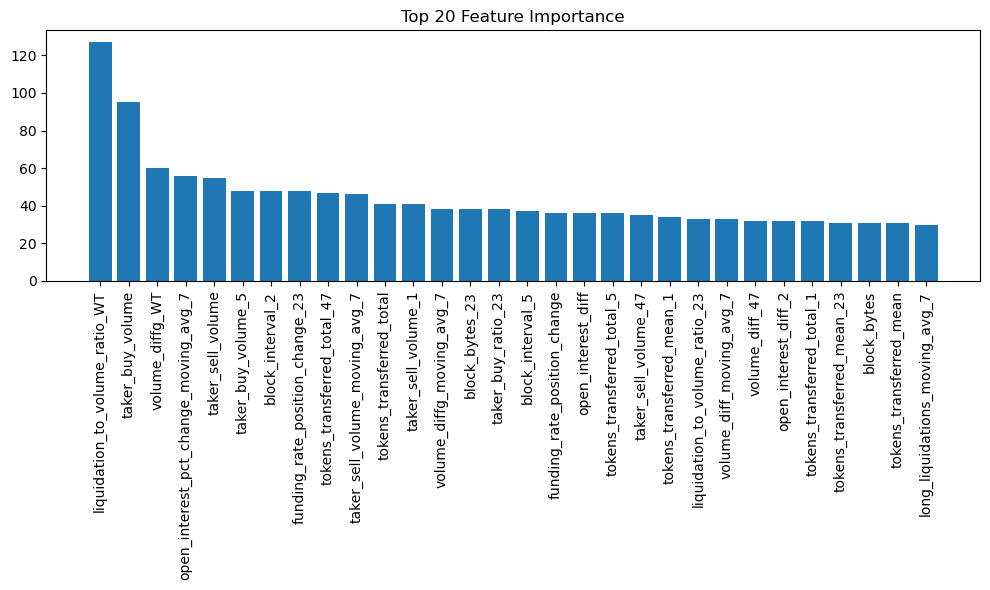

In [ ]:
# 모델 학습 후 특성 중요도 확인
feature_importance = lgb_model.feature_importance(importance_type='split')
feature_names = lgb_model.feature_name()

# 특성 중요도를 데이터프레임으로 변환하고 정렬
import pandas as pd
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(feature_importance_df)

# 상위 30개 특성의 중요도를 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['feature'][:30], feature_importance_df['importance'][:30])
plt.xticks(rotation=90)
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()


In [ ]:
# importance 기준으로 오름차순 정렬
feature_importance_df_sorted = feature_importance_df.sort_values('importance', ascending=True)

# 하위 n개 선택
n = 500
bottom = feature_importance_df_sorted.head(n)

# 결과 출력 (모든 행 표시)
print(f"하위 {n}개 특성:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(bottom)

하위 500개 특성:
                                       feature  importance
336                             supply_total_1           0
340                            supply_total_47           0
401                    liquidation_usd_diffg_1           0
32                                supply_total           0
452                   hashrate_to_difficulty_2           0
454                  hashrate_to_difficulty_23           0
12                        taker_buy_sell_ratio           0
166                   buy_sell_volume_ratio_WT           0
50                                        week           0
327                      fees_reward_percent_2           0
328                      fees_reward_percent_5           0
329                     fees_reward_percent_23           0
330                     fees_reward_percent_47           0
403                    liquidation_usd_diffg_5           0
337                             supply_total_2           0
338                             supply_total

In [ ]:
# importance 기준으로 오름차순 정렬
feature_importance_df_sorted = feature_importance_df.sort_values('importance', ascending=False)

# 하위 n개 선택
n = 500
bottom = feature_importance_df_sorted.head(n)

# 결과 출력 (모든 행 표시)
print(f"하위 {n}개 특성:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(bottom)

하위 500개 특성:
                                       feature  importance
170             liquidation_to_volume_ratio_WT         127
8                             taker_buy_volume          95
165                            volume_diffg_WT          60
110      open_interest_pct_change_moving_avg_7          56
9                            taker_sell_volume          55
444            funding_rate_position_change_23          48
267                           block_interval_2          48
218                         taker_buy_volume_5          48
350                tokens_transferred_total_47          47
71              taker_sell_volume_moving_avg_7          46
34                    tokens_transferred_total          41
221                        taker_sell_volume_1          41
259                             block_bytes_23          38
108                  volume_diffg_moving_avg_7          38
229                         taker_buy_ratio_23          38
268                           block_interval

## Cross Validation 활용 부분

In [ ]:
# # 교차 검증 수행
# cv_results = lgb.cv(
#     params,
#     train_data,
#     num_boost_round=1000,
#     nfold=5,
#     stratified=True,
#     callbacks=[lgb.early_stopping(stopping_rounds=50)],
#     return_cvbooster=True
# )

# # 교차 검증 결과 출력
# print('Best num_boost_round:', len(cv_results['valid multi_logloss-mean']))
# print('Best CV score:', cv_results['valid multi_logloss-mean'][-1])

In [ ]:
# # CVBooster 객체 가져오기
# cv_booster = cv_results['cvbooster']

# # 새로운 데이터에 대한 예측
# predictions = cv_booster.predict(x_train.values)


In [ ]:
# # 1. 예측값 평균 계산
# avg_predictions = np.mean(predictions, axis=0)

# # 2. 클래스 예측
# y_valid_pred_class = np.argmax(avg_predictions, axis=1)

# # 3. 성능 평가
# accuracy = accuracy_score(y_valid, y_valid_pred_class)
# auroc = roc_auc_score(y_valid, avg_predictions, multi_class="ovr")

# print(f"acc: {accuracy}, auroc: {auroc}")

# # 추가된 confusion matrix 구현 부분
# evaluate_model(y_valid, y_valid_pred_class, "cv_lgb_model")

# 원본의 재학습, 추론, 결과 파일 생성 부분

In [ ]:
# # performance 체크후 전체 학습 데이터로 다시 재학습
# x_train = train_df.drop(["target", "ID"], axis = 1)
# y_train = train_df["target"].astype(int)
# train_data = lgb.Dataset(x_train, label=y_train)
# lgb_model = lgb.train(
#     params=params,
#     train_set=train_data,
# )

### Inference

In [ ]:
# # lgb predict
# y_test_pred = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
# y_test_pred_class = np.argmax(y_test_pred, axis = 1)

### Output File Save

In [ ]:
# # output file 할당후 save 
# submission = submission.assign(target = y_test_pred_class)
# submission.to_csv("output.csv", index=False)

# 영찬이 앙상블 부분

### LGBM based Bagging 학습

In [20]:
# from sklearn.ensemble import BaggingClassifier
# from lightgbm import LGBMClassifier

# # LightGBM을 기반으로 하는 Bagging Classifier
# bagging_model = BaggingClassifier(
#     base_estimator=LGBMClassifier(**params),
#     n_estimators=10,  # Bagging에서 사용할 모델 수
#     random_state=42
# )

# # 학습
# bagging_model.fit(x_train, y_train)

# # 예측
# y_valid_pred = bagging_model.predict(x_valid)

# # 평가
# accuracy = accuracy_score(y_valid, y_valid_pred)
# auroc = roc_auc_score(y_valid, bagging_model.predict_proba(x_valid), multi_class="ovr")

# print(f"Bagging - acc: {accuracy}, auroc: {auroc}")

In [21]:
# from lightgbm import LGBMClassifier

# # train_test_split 으로 valid set, train set 분리
# x_train, x_valid, y_train, y_valid = train_test_split(
#     train_df.drop(["target", "ID"], axis = 1), 
#     train_df["target"].astype(int), 
#     test_size=0.2,
#     random_state=42,
# )

# # LightGBM 모델 생성 및 학습
# lgb_model = LGBMClassifier(
#     boosting_type="gbdt",
#     objective="multiclass",
#     num_class=4,
#     num_leaves=50,
#     learning_rate=0.05,
#     n_estimators=30,
#     random_state=42,
#     verbose=-1
# )

# lgb_model.fit(
#     x_train, 
#     y_train,
#     eval_set=[(x_valid, y_valid)],
#     eval_metric='multi_logloss'
# )


#### XGBoost 학습

In [22]:
# import xgboost as xgb
# from sklearn.ensemble import VotingClassifier

# # train_test_split 으로 valid set, train set 분리
# x_train, x_valid, y_train, y_valid = train_test_split(
#     train_df.drop(["target", "ID"], axis = 1), 
#     train_df["target"].astype(int), 
#     test_size=0.2,
#     random_state=42,
# )

# xgb_params = {
#     'objective': 'multi:softprob',
#     'num_class': 4,
#     'learning_rate': 0.05,
#     'max_depth': 6,
#     'n_estimators': 100,
#     'random_state': 42
# }

# # XGBoost 모델 학습 및 성능 체크
# xgb_model = xgb.XGBClassifier(**xgb_params)
# xgb_model.fit(x_train, y_train)


#### Ensenble

In [23]:
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import KFold
# from sklearn.base import BaseEstimator, ClassifierMixin, clone
# from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
# from sklearn.utils.multiclass import unique_labels

# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# # 데이터 준비
# X = train_df.drop(["target", "ID"], axis=1)
# y = train_df["target"].astype(int)

# # 교차 검증을 위한 KFold 정의
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # 1. Voting 앙상블
# voting_hard = VotingClassifier(
#     estimators=[('lgb', lgb_model), ('xgb', xgb_model), ('rf', rf_model)],
#     voting='hard'
# )

# voting_soft = VotingClassifier(
#     estimators=[('lgb', lgb_model), ('xgb', xgb_model), ('rf', rf_model)],
#     voting='soft'
# )

# # 2. Bagging 앙상블
# bagging = BaggingClassifier(base_estimator=lgb_model, n_estimators=10, random_state=42)

# # 3. Stacking 앙상블

# class StackingEnsemble(BaseEstimator, ClassifierMixin):
#     def __init__(self, base_models, meta_model, n_folds=5):
#         self.base_models = base_models
#         self.meta_model = meta_model
#         self.n_folds = n_folds

#     def fit(self, X, y):
#         # Check that X and y have correct shape
#         X, y = check_X_y(X, y)
#         # Store the classes seen during fit
#         self.classes_ = unique_labels(y)

#         self.base_models_ = [list() for _ in self.base_models]
#         self.meta_model_ = clone(self.meta_model)
#         kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
#         out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
#         for i, model in enumerate(self.base_models):
#             for train_index, holdout_index in kfold.split(X, y):
#                 instance = clone(model)
#                 self.base_models_[i].append(instance)
#                 instance.fit(X[train_index], y[train_index])
#                 y_pred = instance.predict_proba(X[holdout_index])
#                 out_of_fold_predictions[holdout_index, i] = y_pred[:, 1]
        
#         self.meta_model_.fit(out_of_fold_predictions, y)
#         return self

#     def predict(self, X):
#         # Check is fit had been called
#         check_is_fitted(self)
#         # Input validation
#         X = check_array(X)
#         meta_features = np.column_stack([
#             np.column_stack([model.predict_proba(X)[:, 1] for model in base_models]).mean(axis=1)
#             for base_models in self.base_models_ ])
#         return self.meta_model_.predict(meta_features)

#     def predict_proba(self, X):
#         # Check is fit had been called
#         check_is_fitted(self)
#         # Input validation
#         X = check_array(X)
#         meta_features = np.column_stack([
#             np.column_stack([model.predict_proba(X)[:, 1] for model in base_models]).mean(axis=1)
#             for base_models in self.base_models_ ])
#         return self.meta_model_.predict_proba(meta_features)

# stacking = StackingEnsemble(
#     base_models=(lgb_model, xgb_model, rf_model),
#     meta_model=LogisticRegression()
# )

# from sklearn.model_selection import cross_val_predict

# accuracy_scores = cross_val_score(stacking, X, y, cv=kf, scoring='accuracy', error_score='raise')
# # AUROC 계산
# if hasattr(stacking, "predict_proba"):
#     y_pred_proba = cross_val_predict(stacking, X, y, cv=kf, method='predict_proba')
#     auroc_score = roc_auc_score(y, y_pred_proba, multi_class='ovr')
# else:
#     auroc_score = None

# print("Stacking")
# print(f"  - 평균 정확도: {accuracy_scores.mean()} (+/- {accuracy_scores.std() * 2})")
# if auroc_score:
#     print(f"  - AUROC: {auroc_score}")
# else:
#     print("  - AUROC: Not available")
# print()



In [24]:
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import cross_val_predict

# # 모델 리스트 (VotingHard 제외)
# models = [lgb_model, xgb_model, rf_model, voting_soft, bagging]
# model_names = ['LightGBM', 'XGBoost', 'RandomForest', 'VotingSoft', 'Bagging']

# # 각 모델의 교차 검증 수행
# for name, model in zip(model_names, models):
#     # 정확도 계산
#     accuracy_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    
#     # AUROC 계산
#     if hasattr(model, "predict_proba"):
#         y_pred_proba = cross_val_predict(model, X, y, cv=kf, method='predict_proba')
#         auroc_score = roc_auc_score(y, y_pred_proba, multi_class='ovr')
#     else:
#         auroc_score = None
    
#     print(f"{name}:")
#     print(f"  - 평균 정확도: {accuracy_scores.mean()} (+/- {accuracy_scores.std() * 2})")
#     if auroc_score:
#         print(f"  - AUROC: {auroc_score}")
#     else:
#         print("  - AUROC: Not available")
#     print()


In [25]:

# # 최종 모델 선택 및 전체 데이터로 학습 (AUROC 기준)
# best_model = models[np.argmax([
#     roc_auc_score(y, cross_val_predict(model, X, y, cv=kf, method='predict_proba'), multi_class='ovr')
#     if hasattr(model, "predict_proba") else 0 
#     for model in models
# ])]

# best_model.fit(X, y)

# # 테스트 데이터에 대한 예측
# X_test = test_df.drop(["target", "ID"], axis=1)
# y_test_pred = best_model.predict(X_test)
# if hasattr(best_model, "predict_proba"):
#     y_test_pred_proba = best_model.predict_proba(X_test)

# # 제출 파일 생성
# submission = submission.assign(target=y_test_pred)
# submission.to_csv("output_best_ensemble.csv", index=False)

# print(f"Best model: {type(best_model).__name__}")

### Inference

앙상블의 inference & save 과정.

In [26]:
# # performance 체크후 전체 학습 데이터로 다시 재학습 - LGBM Bagging(알아서 주석 빼고 실행)

# x_train = train_df.drop(["target", "ID"], axis = 1)
# y_train = train_df["target"].astype(int)
# train_data = lgb.Dataset(x_train, label=y_train)
# bagging_model.fit(x_train, y_train)

# y_test_pred = bagging_model.predict(test_df.drop(["target", "ID"], axis = 1))


# submission = submission.assign(target = y_test_pred_class)
# submission.to_csv("0925_median_output.csv", index=False)